Query on Cosmohub to get Gaia EDR3 data:

    SELECT `solution_id`, `designation`, `source_id`, `ra`, `ra_error`, `dec`, `dec_error`, `parallax`, `parallax_error`, `pm`, `pmra`, `pmra_error`, `pmdec`, `pmdec_error`, `ra_dec_corr`, `ra_parallax_corr`, `ra_pmra_corr`, `ra_pmdec_corr`, `dec_parallax_corr`, `dec_pmra_corr`, `dec_pmdec_corr`, `parallax_pmra_corr`, `parallax_pmdec_corr`, `pmra_pmdec_corr`, `visibility_periods_used`, `astrometric_sigma5d_max`, `ruwe`, `duplicated_source`, `phot_g_mean_flux`, `phot_g_mean_flux_error`, `phot_g_mean_flux_over_error`, `phot_g_mean_mag`, `phot_bp_mean_flux`, `phot_bp_mean_flux_error`, `phot_bp_mean_flux_over_error`, `phot_bp_mean_mag`, `phot_rp_mean_flux`, `phot_rp_mean_flux_error`, `phot_rp_mean_flux_over_error`, `phot_rp_mean_mag`, `dr2_radial_velocity`, `dr2_radial_velocity_error`, `l`, `b`, `phot_bp_rp_excess_factor` FROM gaia_edr3 WHERE `phot_g_mean_mag` < 18.5 AND (`b` > 30 OR `b` < -30)
    
    
Validation plots:
- Sky density in bins of magnitude (healpix)
- xy plane density

Parameters:
- $z_\odot$
- orientation of the galactic plane

These cartesian coordinates are a rotation $\mathbf{M}$ away from the ICRS cartesian coordinates
$$
\textbf{x} = (x, y, z) = \mathbf{M}\,\textbf{x}_{\textrm{ICRS}}
$$
where one angle in the rotation matrix is set by the (fixed) sky position of the Galactic center, one is set by the Sun's height above the midplane and distance to the Galactic center, and one is set by the orientation of the Galactic plane (on the sky?) or position angle or "roll" or whatever.

In the rotated "Galactocentric" coordinates $\textbf{x}$:
$$
\rho(\textbf{x}) = \rho_0 \, \left[
    \textrm{sech}^2\left(\frac{z + z_\odot}{2\,h_1}\right) + 
    \alpha \, \textrm{sech}^2\left(\frac{z + z_\odot}{2\,h_2}\right)
    \right]
$$
where the density is assumed to be uniform in $x, y$ and only depend on $z$.


Notes and TODO:

- Basis functions? double Sech^2 model plus Chebyshev polynomials??
- Are there orthogonal basis functions for PDFs such that the integral of sum is always 1?

$$
f(x) = \sum_k \alpha_k \, f_k(x)\\
\int \textrm{d}x \, f(x) = 1\\
\int \textrm{d}x \, \sum_k \alpha_k \, f_k(x) = 1\\
\sum_k \alpha_k \, \int \textrm{d}x \,  f_k(x) = 1
$$
so I guess this holds if all
$$
\int \textrm{d}x \,  f_k(x) = 1
$$

In [47]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
import healpy as hp

from pyia import GaiaData

from coord_helpers import gal_to_schmagal, schmagal_to_gal
from model_helpers import (ln_density, ln_normal, ln_two_sech2, ln_exp, ln_uniform,
                           ln_integrand, get_ln_Veff,
                           ln_likelihood)
from simulate_helpers import invt_sample_z

In [2]:
usys = [u.pc, u.rad, u.Msun, u.Myr]

# TODO: set to new Reid value, remeasured at epoch by me
_gal = coord.Galactocentric().galcen_coord.transform_to(coord.Galactic())
sgrA = coord.SphericalRepresentation(
    _gal.l,
    _gal.b,
    8.2*u.kpc
)
sgrA

<SphericalRepresentation (lon, lat, distance) in (deg, deg, kpc)
    (5.32967851e-05, -8.2009012e-05, 8.2)>

In [4]:
# ---------------------------
# # |b| > 30, G < 18.5
# allg = GaiaData('/mnt/home/apricewhelan/data/GaiaEDR3/Gaia-b30-G18.5.fits')

# G_max = 18.5 * u.mag
# min_b = 30 * u.deg
# max_dist = 1.5 * u.kpc

# ---------------------------
# |b| > 15, G < 16, plx > 0.5
allg = GaiaData('/mnt/home/apricewhelan/data/GaiaEDR3/Gaia-b15-G16-plx0.5.fits')

G_max = 16 * u.mag
min_b = 15 * u.deg
max_dist = 1.5 * u.kpc

In [5]:
mask = (
    (allg.parallax > coord.Distance(max_dist).parallax) & 
    ((allg.parallax / allg.parallax_error) > 5)
)
g = allg[mask]

len(g), len(allg)

(15666146, 19051070)

In [ ]:
g.get_skycoord()

In [6]:
# Raw photometry
# MG = g.phot_g_mean_mag - g.distmod
# BPRP = g.bp_rp

# attempt at extinction-correcting the photometry:
MG = g.get_G0() - g.distmod
BPRP = g.get_BP0() - g.get_RP0()

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:33: RuntimeWarning: overflow encountered in multiply
  AG = F1(curbp)*A0
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:34: RuntimeWarning: overflow encountered in multiply
  Abp = F2(curbp)*A0
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:35: RuntimeWarning: overflow encountered in multiply
  Arp = F3(curbp)*A0
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:36: RuntimeWarning: overflow encountered in add
  curbp1 = bp-rp-Abp+Arp
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


Select the upper main sequence based on:
https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

In [7]:
MG_lim = [1, 4] * u.mag  # A0 through G0
theory_max_dist = coord.Distance(distmod=G_max - max(MG_lim))
faintest_G = np.max(MG_lim) + coord.Distance(max_dist).distmod
print(f"rough maximum distance for completeness: {theory_max_dist:.0f} (but I imposed <{max_dist:.1f})")
print(f"faintest a star in this selection can be: {faintest_G:.1f}")

rough maximum distance for completeness: 3 kpc (but I imposed <1.5 kpc)
faintest a star in this selection can be: 14.9 mag


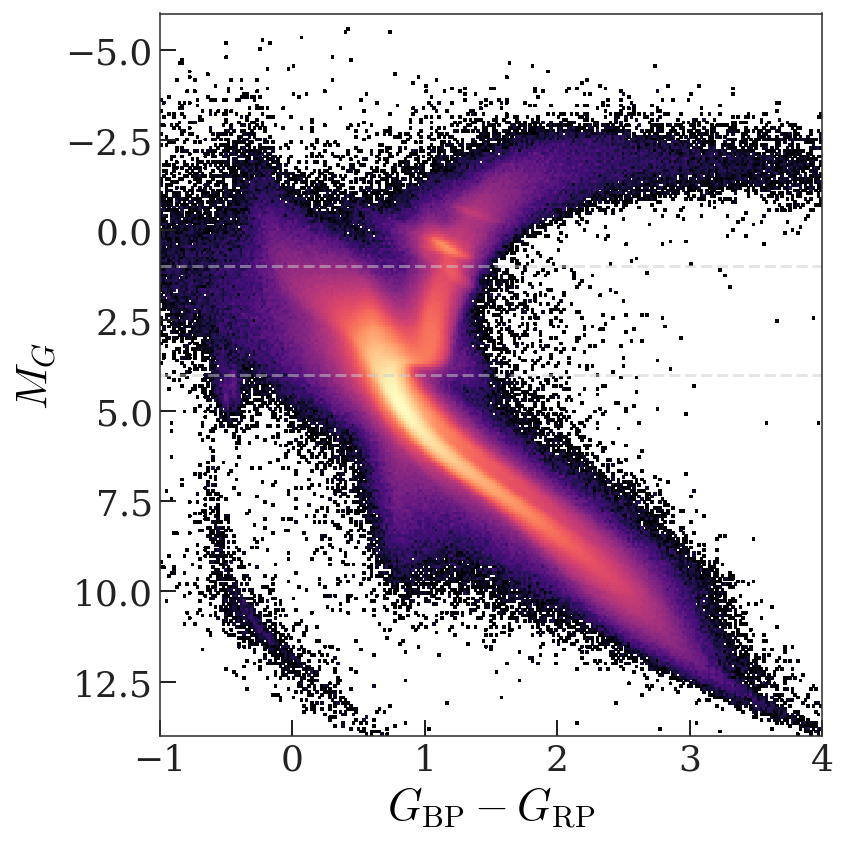

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

bins = (np.linspace(-1, 4, 256),
        np.linspace(-6, 14, 256))

ax.hist2d(
    BPRP.value, 
    MG.value,
    bins=bins,
    norm=mpl.colors.LogNorm()
)

for lim in MG_lim:
    ax.axhline(lim.value, marker='', color='#cccccc', 
               linestyle='--', alpha=0.5)

ax.set_ylim(14, -6)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')

fig.tight_layout()

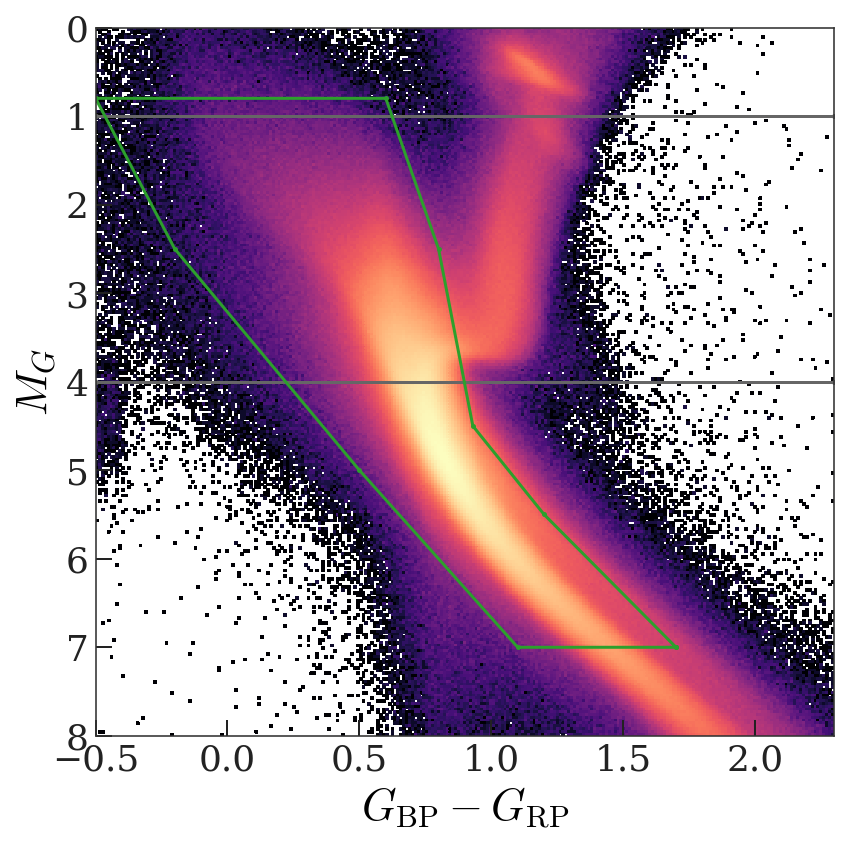

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist2d(
    BPRP.value, 
    MG.value,
    bins=(np.linspace(-0.5, 2.3, 256),
          np.linspace(0, 8, 256)),
    norm=mpl.colors.LogNorm()
)

for lim in MG_lim:
    ax.axhline(lim.value)
    
nodes = np.array([
    [1.7, 7],
    [1.1, 7],
    [0.5, 5],
    [-0.2, 2.5],
    [-0.5, 0.8],
    [0.6, 0.8],
    [0.8, 2.5],
    [0.93, 4.5],
    [1.2, 5.5],
    [1.7, 7]
])
ax.plot(nodes[:, 0], nodes[:, 1], color='tab:green')
path_ = mpl.path.Path(nodes)
cmd_mask = (
    path_.contains_points(np.stack((BPRP.value, MG.value)).T) &
    (MG > MG_lim[0]) &
    (MG < MG_lim[1])
)

ax.set_ylim(8, 0)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')
fig.tight_layout()

In [18]:
mask = (
    cmd_mask
)
cmd_mask.sum(), mask.sum()

(3318300, 3318300)

In [19]:
ms_g = g[mask]
plx_snr = (ms_g.parallax / ms_g.parallax_error).decompose().value
(ms_g.ruwe < 1.4).sum() / len(ms_g), (plx_snr > 10).sum() / len(ms_g)

(0.8531106289365036, 0.9898830726576862)

In [57]:
np.isfinite(ms_g.dr2_radial_velocity).sum() / len(ms_g)

0.2579549769460266

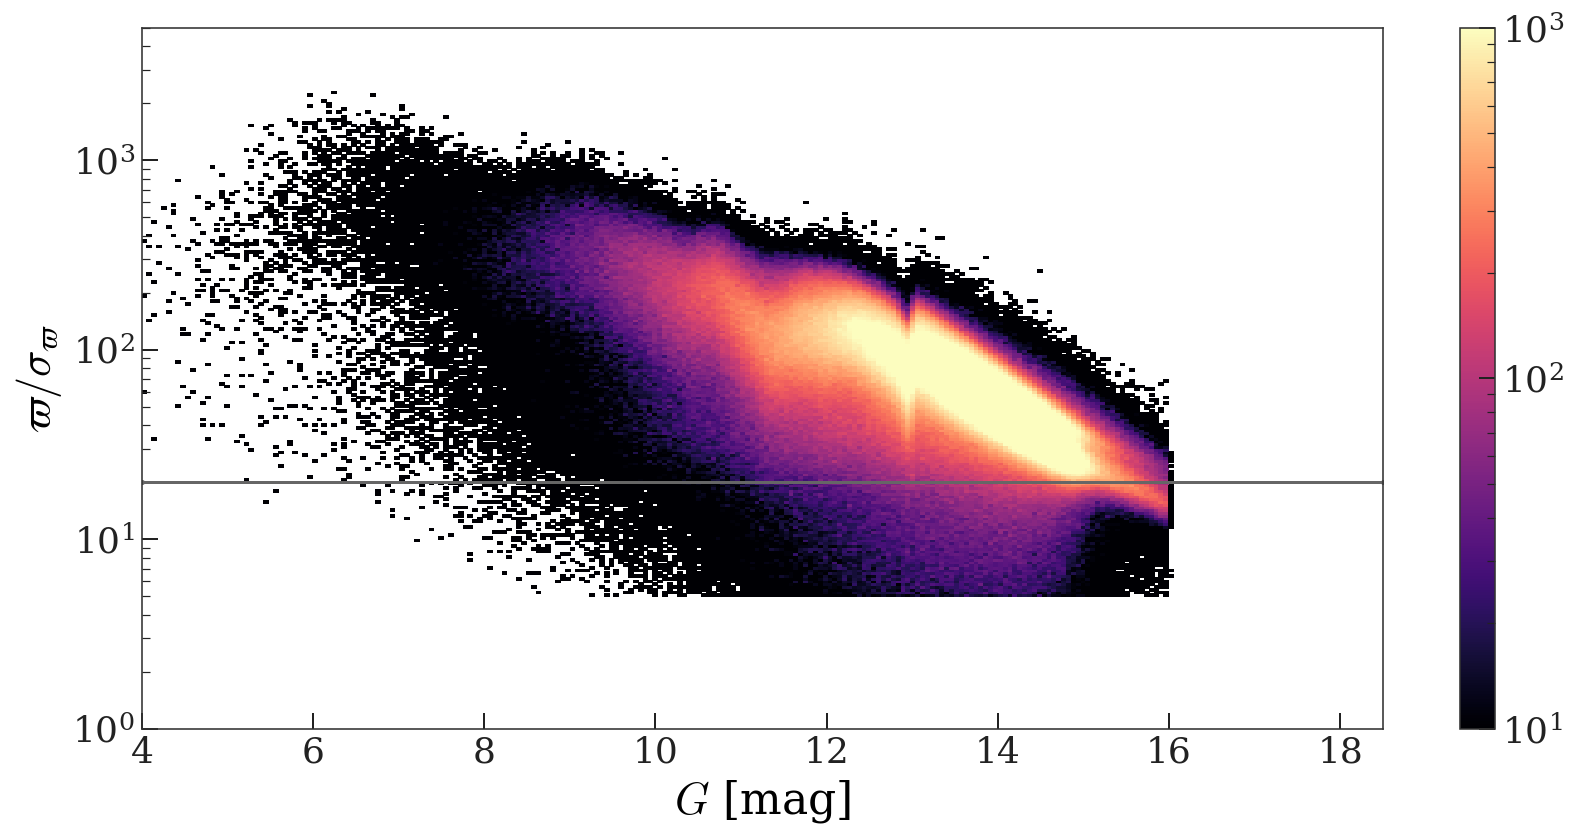

In [20]:
plt.figure(figsize=(12, 6))
plt.hist2d(
    ms_g.phot_g_mean_mag.value, 
    plx_snr,
    bins=(np.linspace(4, 18.5, 256),
          np.geomspace(1, 5e3, 256)),
    norm=mpl.colors.LogNorm(vmin=10, vmax=1e3)
)
plt.axhline(20.)
plt.colorbar()
plt.yscale('log')
plt.xlabel('$G$ [mag]')
plt.ylabel(r'$\varpi / \sigma_\varpi$')
plt.tight_layout()

In [21]:
gal = ms_g.skycoord.galactic
gal_xyz = gal.represent_as('cartesian').xyz
gal_xyz_kpc = gal_xyz.to_value(u.kpc)

Sky distribution / uniformity of sample:

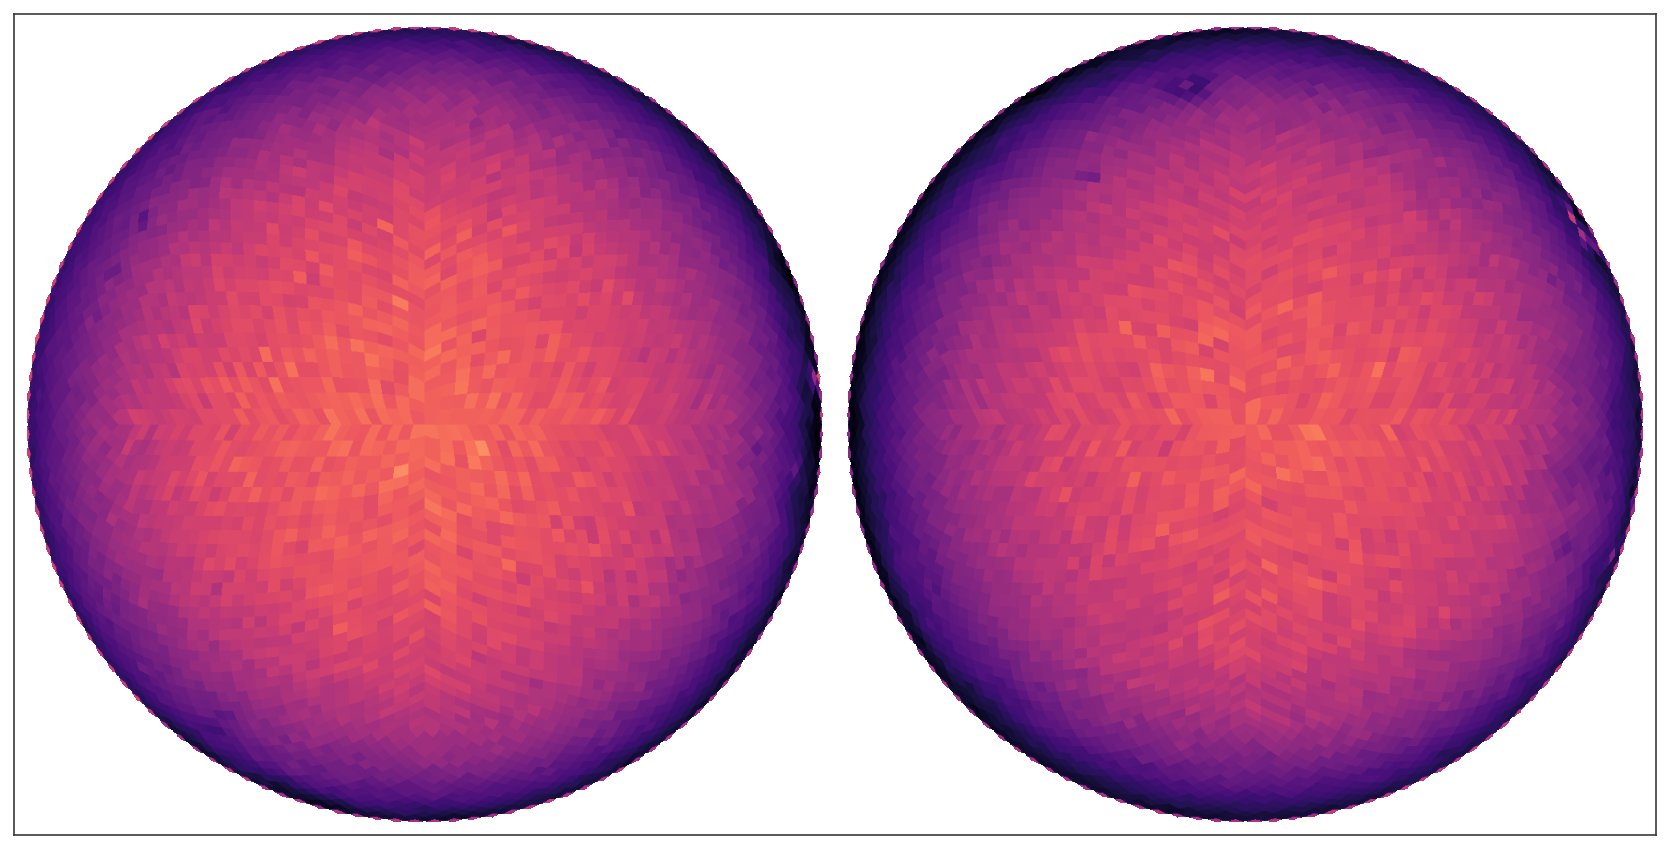

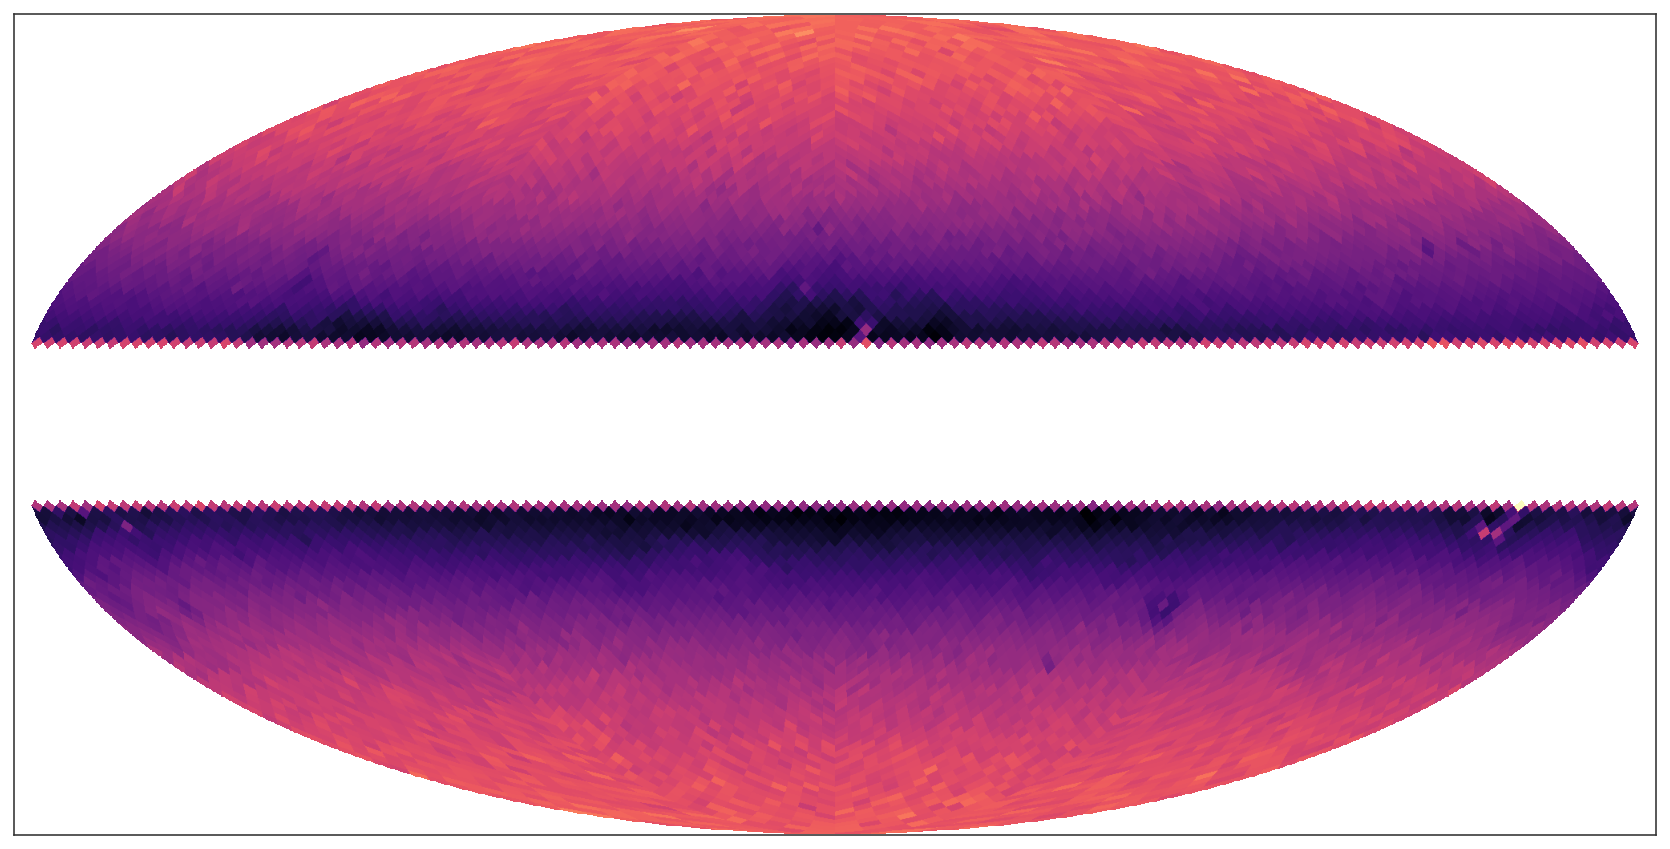

In [22]:
nside = 32
npix = hp.nside2npix(nside)

indices = hp.ang2pix(
    nside, 
    gal.spherical.lon.to_value(u.degree),
    gal.spherical.lat.to_value(u.degree),
    lonlat=True
)

hpxmap = np.zeros(npix, dtype=np.int32)  # int64 if you have a lot of sources!
np.add.at(hpxmap, indices, 1)

func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

for proj in [hp.projector.OrthographicProj(xsize=2048, rot=[0, 90, 90]),
             hp.projector.MollweideProj(xsize=2048)]:
    img = proj.projmap(hpxmap, func)

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(
        img, 
        origin='lower', 
        extent=proj.get_extent(),
        cmap='magma_r',
        norm=mpl.colors.LogNorm()
    )
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.tight_layout()

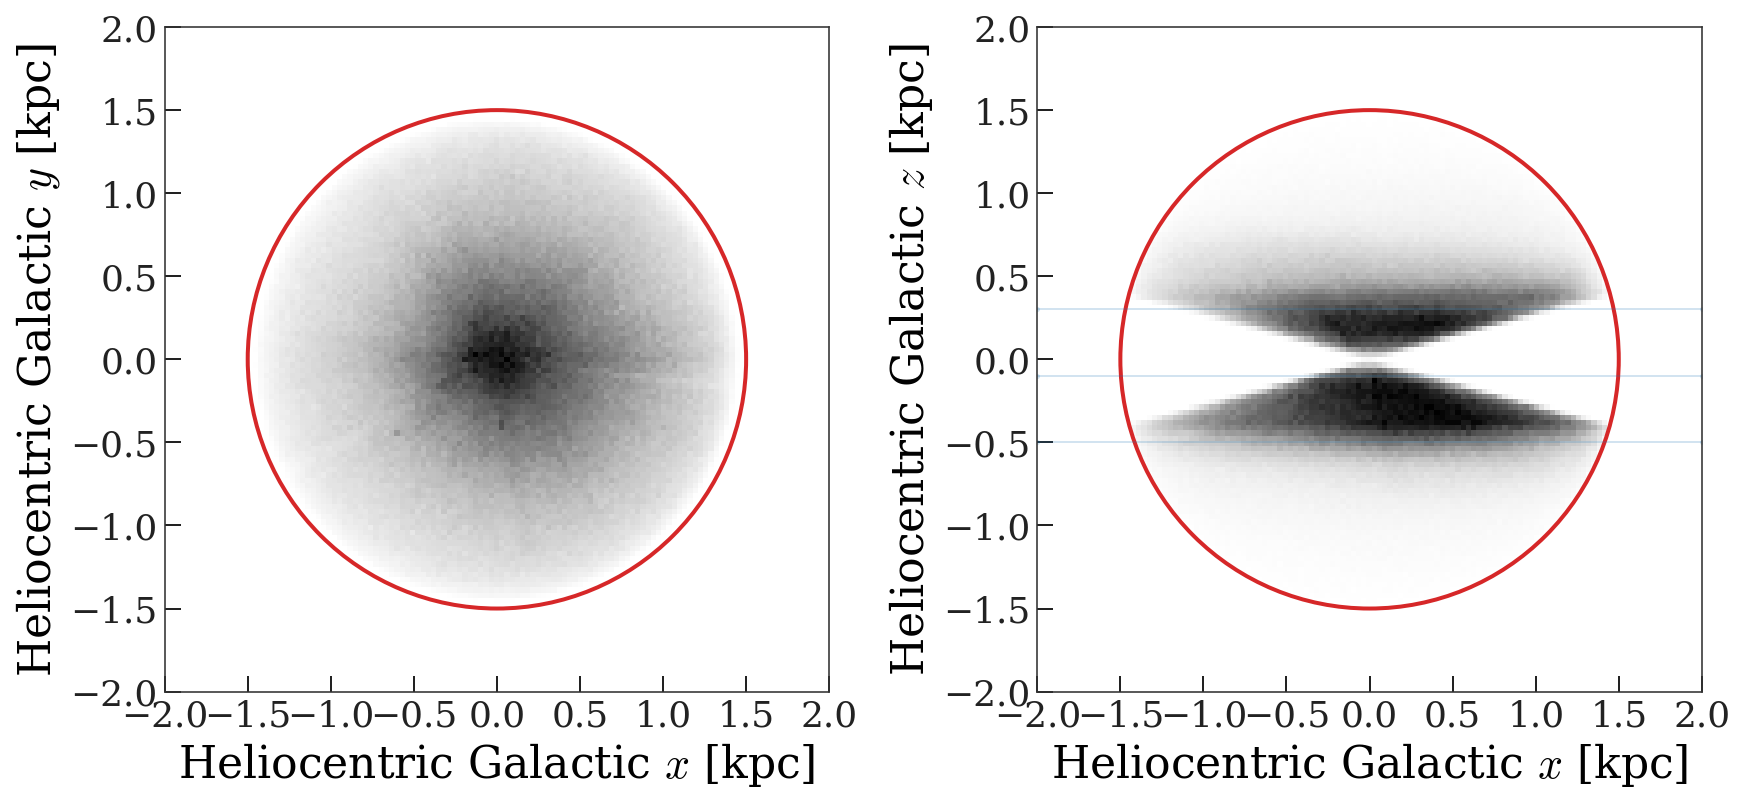

In [24]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-2, 2)
for ax, coords, labels in zip(axes, 
                              [(gal_xyz_kpc[0], gal_xyz_kpc[1]), 
                               (gal_xyz_kpc[0], gal_xyz_kpc[2])],
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=max_dist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );
    
shit = -0.1
axes[1].axhline(shit, color='tab:blue', lw=1, alpha=0.2)
axes[1].axhline(shit - 0.4, color='tab:blue', lw=1, alpha=0.2)
axes[1].axhline(shit + 0.4, color='tab:blue', lw=1, alpha=0.2)

Make simulated stars and apply selection:

In [25]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
from integrate_helpers import log_simpson


def invt_sample_z(ln_density, size=1, internal_units=None,
                  grid_lim=[-10, 10]*u.kpc, grid_size=4096, 
                  args=(), rng=None):
    """
    Inverse transform sampling to generate "true" z values for simulation:
    """
    if rng is None:
        rng = np.random.default_rng()
    
    if internal_units is None:
        internal_units = [u.pc, u.Myr, u.rad, u.Msun]
    
    zgrid = np.linspace(*grid_lim.decompose(internal_units).value, grid_size)
    hgrid = zgrid[1] - zgrid[0]
    
    pad = 100
    pad_zgrid = np.concatenate((
        np.arange(zgrid[0] - pad*hgrid, zgrid[0], hgrid), 
        zgrid
    ))
    
#     offset = quad(lambda x: np.exp(ln_density(x, *args)), -np.inf, pad_zgrid[0], epsabs=1e-12)
#     print(offset)
#     assert offset[0] > offset[1]

    ln_density_vals = ln_density(pad_zgrid, *args)
    ln_cdf = np.array([
        log_simpson(ln_density_vals[:i], x=pad_zgrid[:i])
        for i in range(pad, len(ln_density_vals))
    ])
    
    cdf = np.exp(ln_cdf)
    interp_f = interp1d(cdf, zgrid, kind='linear')
    z_samples = interp_f(rng.uniform(cdf.min(), cdf.max(), size=size))
    return z_samples * internal_units[0]

In [26]:
N = 5_000_000
fiducial = {
    'h1': 120.,
    'h2': 400.,
    'f': 0.75,
    'zsun': -20.8,
    'roll': 0.
}
rng = np.random.default_rng(42)
z_samples = invt_sample_z(
    ln_two_sech2,
    size=N,
    args=(fiducial['h1'], fiducial['h2'], fiducial['f']),
    rng=rng
).to(u.kpc)
x_samples = rng.uniform(-1, 1, size=N) * max_dist
y_samples = rng.uniform(-1, 1, size=N) * max_dist
xyz_samples = np.stack((x_samples, y_samples, z_samples), axis=0)

sim_gal = coord.CartesianRepresentation(
    schmagal_to_gal(xyz_samples, 
                    sgrA, fiducial['zsun'] * u.pc, fiducial['roll'] * u.rad)
)
sim_gal_xyz = sim_gal.xyz
sim_gal_xyz_kpc = sim_gal.xyz.to_value(u.kpc)
sim_gal = sim_gal.represent_as(coord.SphericalRepresentation)
sim_mask = (
    (np.abs(sim_gal.lat) > min_b) &
    (sim_gal.distance < max_dist)
)

In [27]:
# print(gal.distance.min(), sim_gal.distance[sim_mask].min())
print(gal.distance.max(), sim_gal.distance[sim_mask].max())

8.024406945377248 pc 0.01064998143111541 kpc
1499.9971713895009 pc 1.499999801654151 kpc


In [37]:
RR = np.sqrt(gal_xyz[0]**2 + gal_xyz[1]**2)
sim_RR = np.sqrt(sim_gal_xyz[0]**2 + sim_gal_xyz[1]**2)

_R = 300 * u.pc
_z_min = _R / np.tan(90*u.deg - min_b)
print(_z_min)

shit_mask = (RR < _R) & (np.abs(gal_xyz[2]) > _z_min)
sim_shit_mask = (sim_RR < _R) & (np.abs(sim_gal_xyz[2]) > _z_min)
shit_mask.sum(), len(shit_mask), sim_shit_mask.sum()

80.3847577293368 pc


(294123, 3318300, 114764)

(-1.5, 1.5)

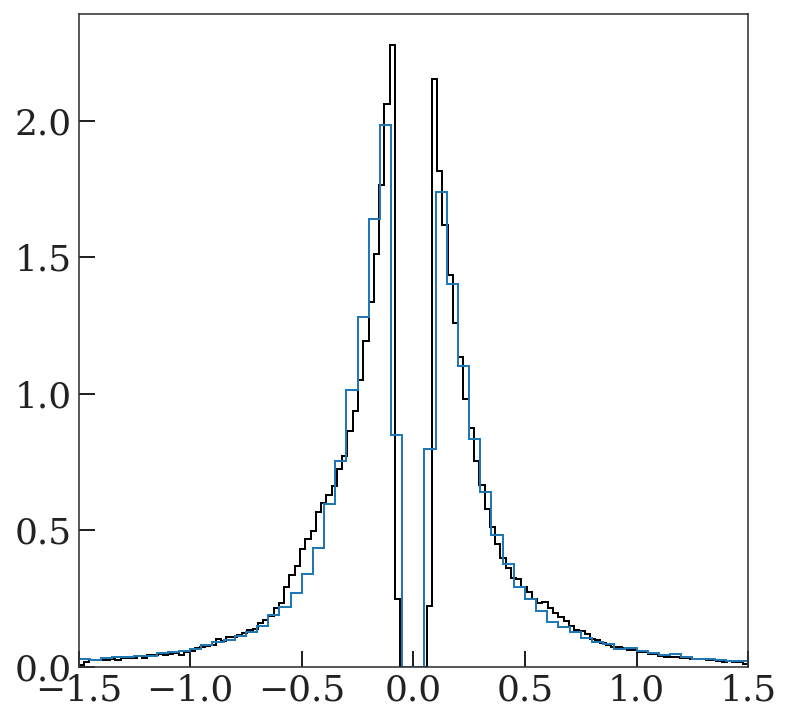

In [38]:
bins = np.linspace(-1.5, 1.5, 128)
plt.hist(gal_xyz_kpc[2][shit_mask], bins=bins, density=True, histtype='step');
bins = np.linspace(bins.min(), bins.max(), 61)
plt.hist(sim_gal_xyz[2].value[sim_shit_mask], density=True, bins=bins, histtype='step');
plt.xlim(-1.5, 1.5)

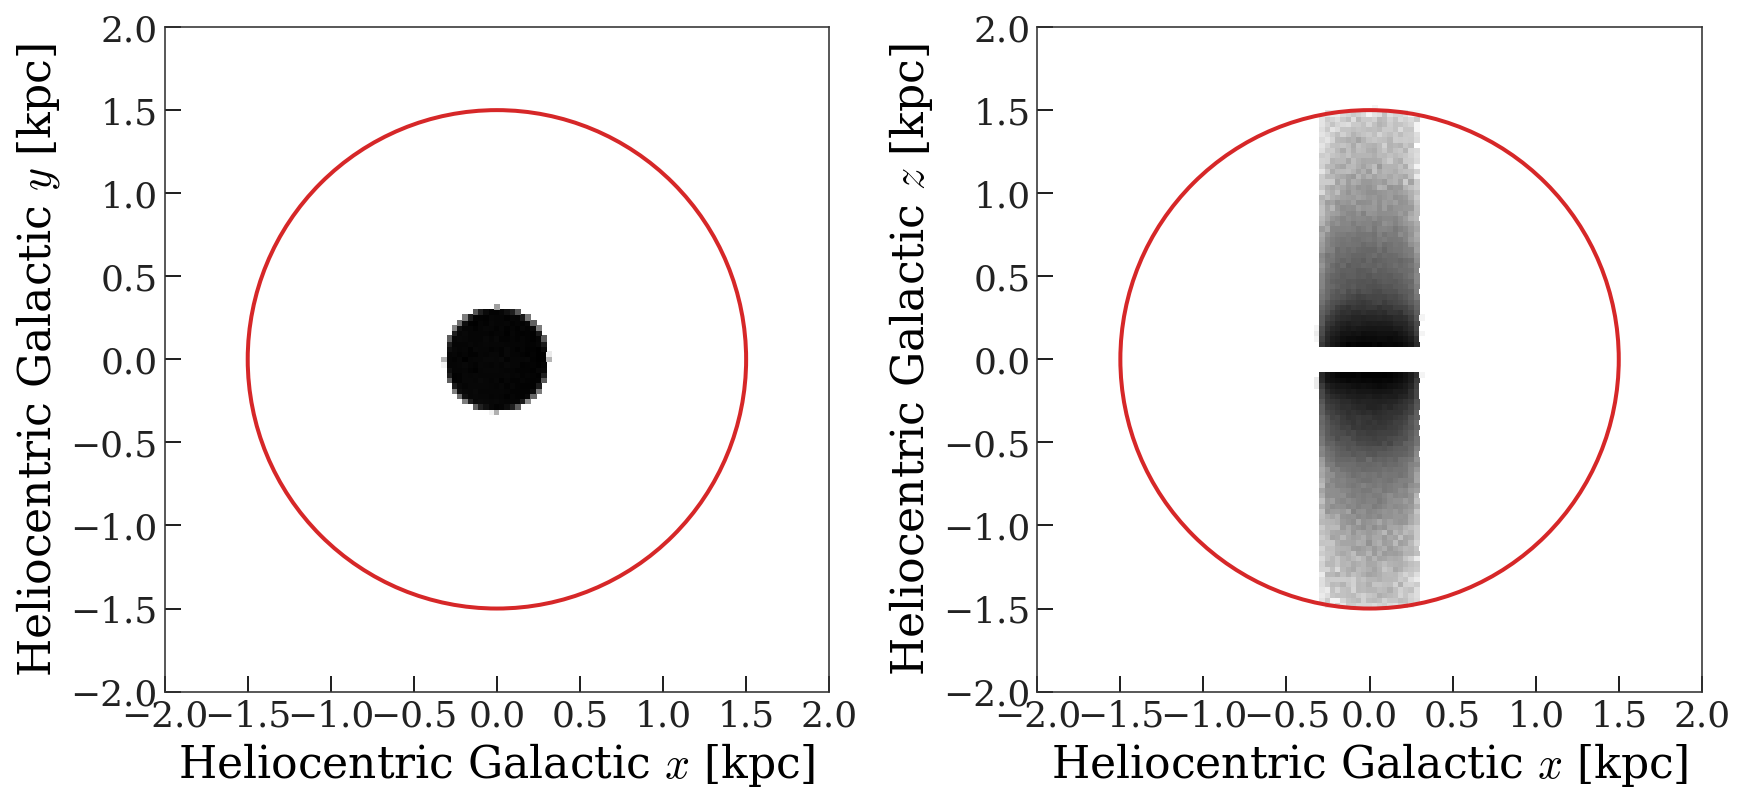

In [39]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-2, 2)
for ax, coords, labels in zip(axes, 
                              [(gal_xyz_kpc[0], gal_xyz_kpc[1]), 
                               (gal_xyz_kpc[0], gal_xyz_kpc[2])],
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0][shit_mask], 
        coords[1][shit_mask], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys',
        norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=max_dist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );

(-1.5, 1.5)

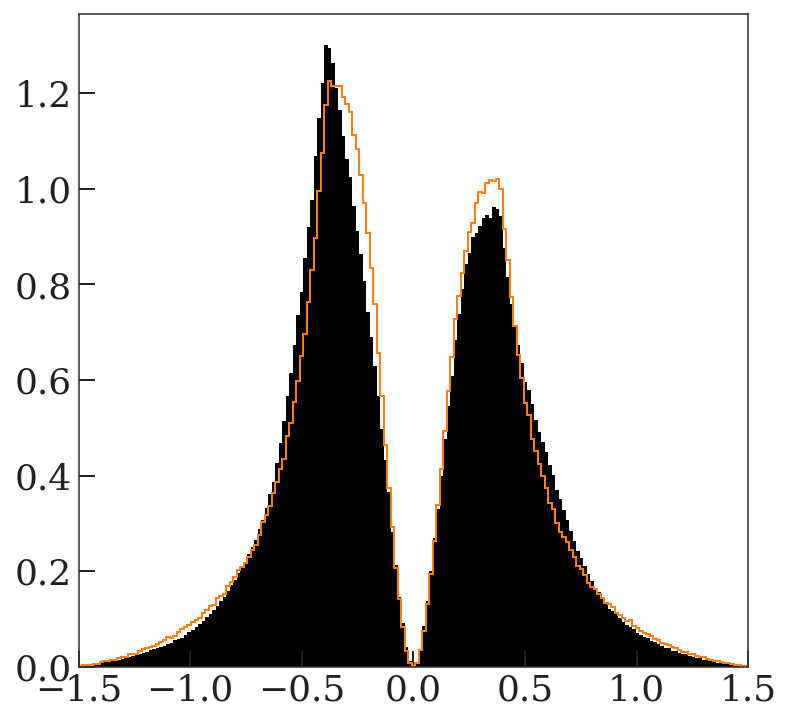

In [40]:
bins = np.linspace(-2, 2, 256)
plt.hist(gal_xyz_kpc[2], bins=bins, density=True);
plt.hist(sim_gal_xyz[2].to_value(u.kpc)[sim_mask], 
         color='tab:orange', bins=bins, histtype='step',
         density=True);
# plt.yscale('log')
plt.xlim(-1.5, 1.5)

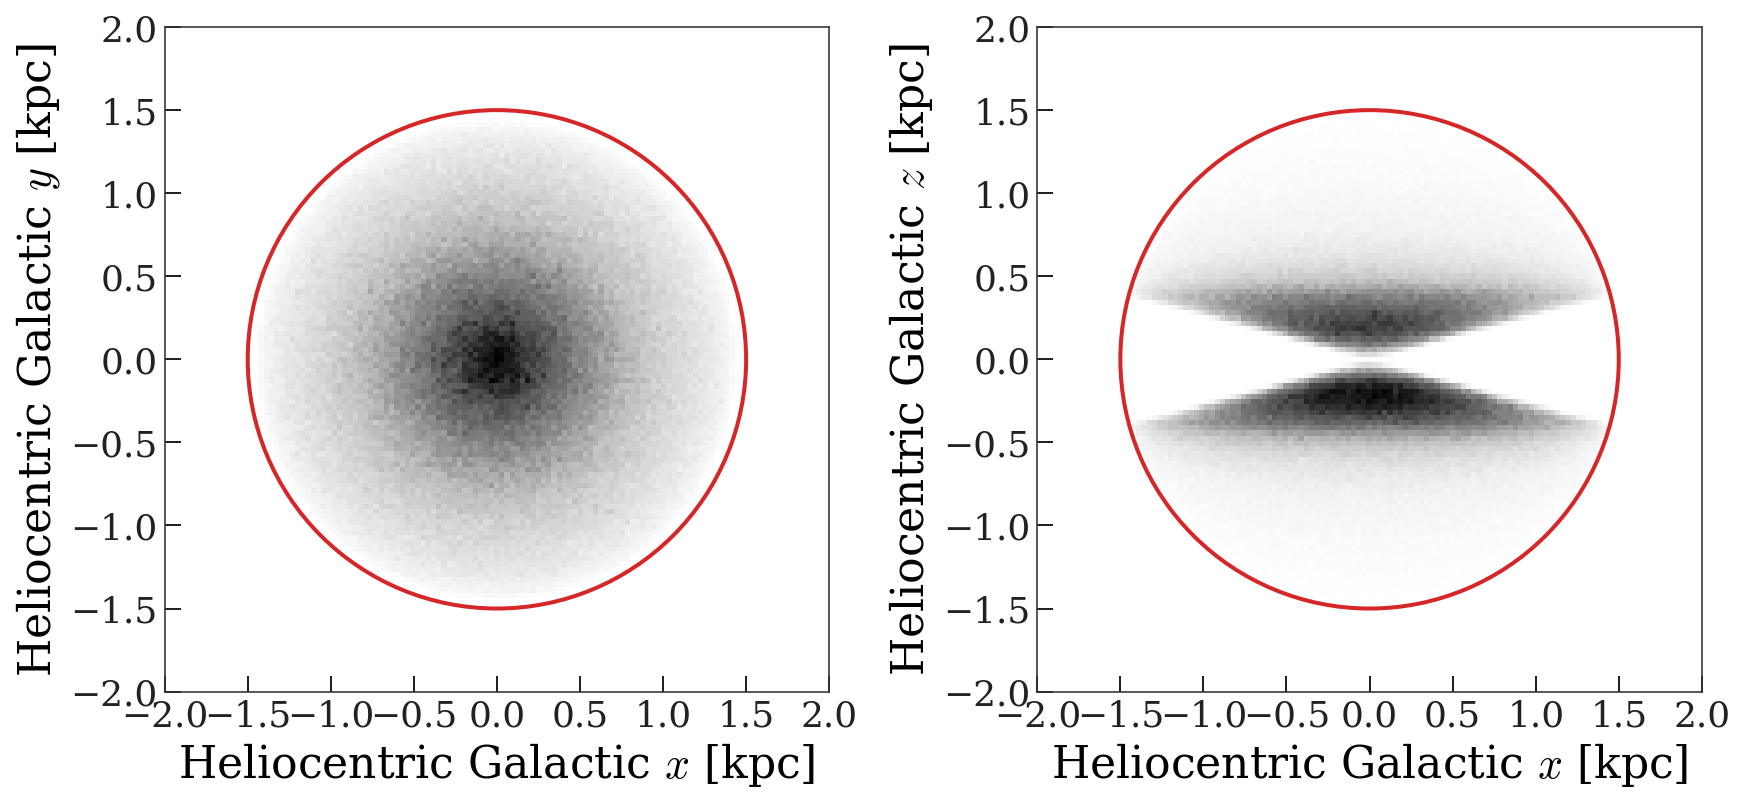

In [32]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-2, 2)
sim_xyz = sim_gal.to_cartesian()[sim_mask].xyz.value
for ax, coords, labels in zip(axes, 
                              [[sim_xyz[0], sim_xyz[1]],
                               [sim_xyz[0], sim_xyz[2]]],
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=max_dist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );

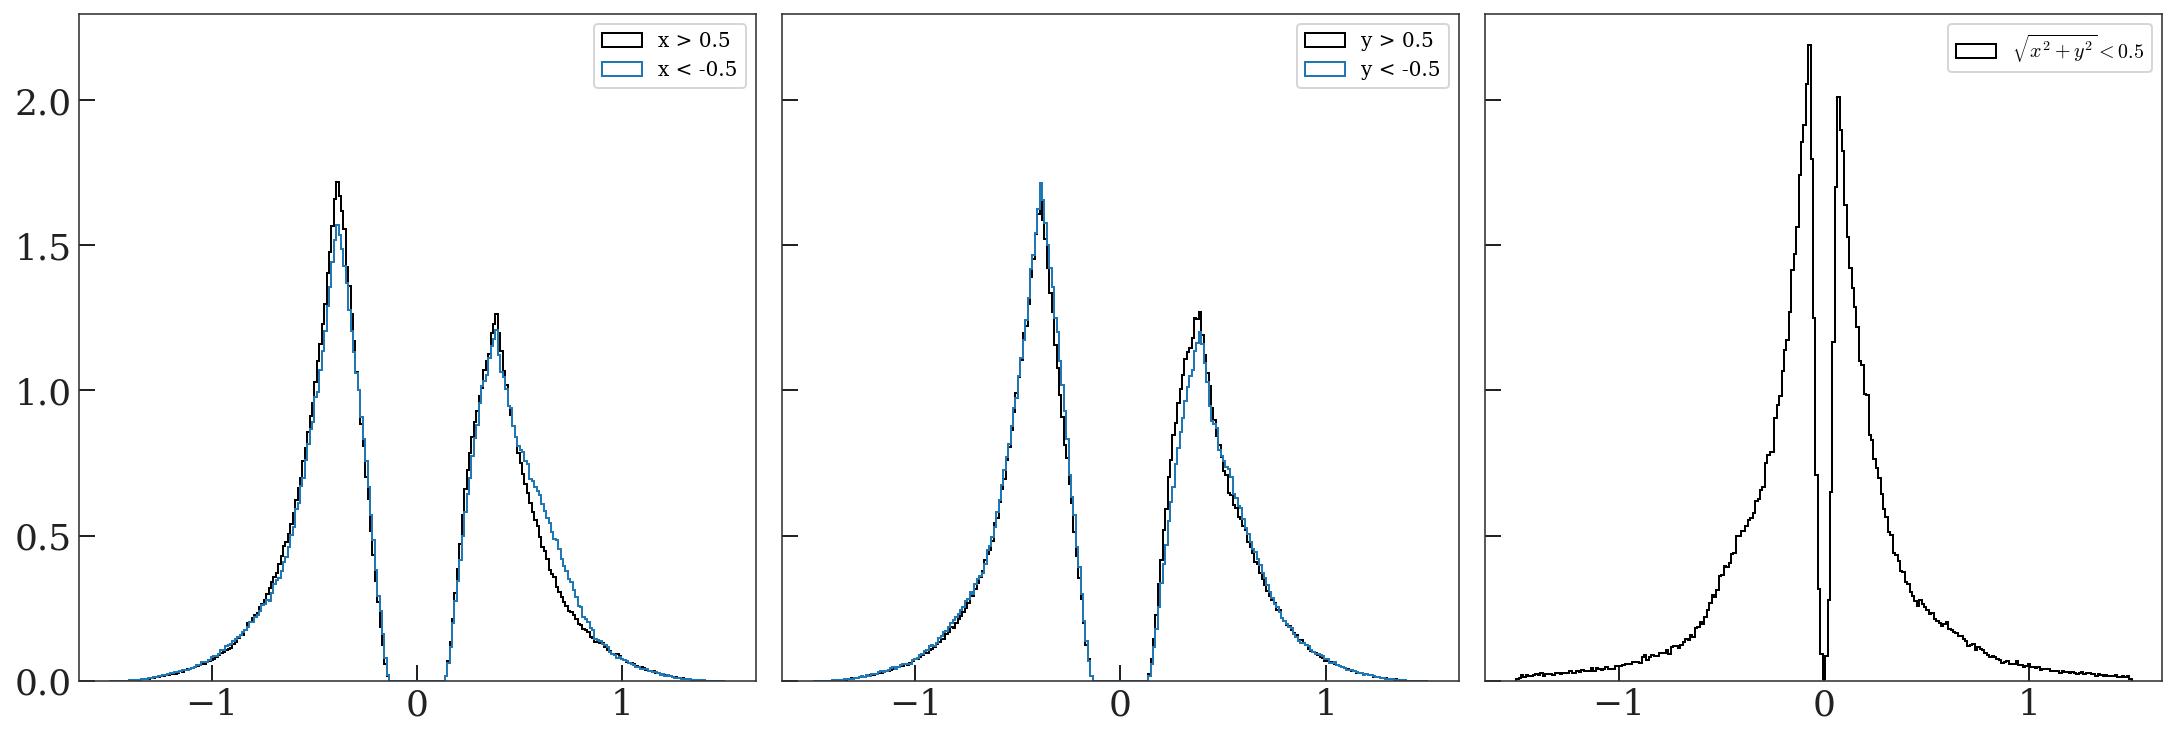

In [53]:
kw = dict(bins=np.linspace(-1.5, 1.5, 256), density=True, histtype='step')

fig, axes = plt.subplots(1, 3, figsize=(15, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

axes[0].hist(gal_xyz_kpc[2][gal_xyz_kpc[0] > 0.5], label='x > 0.5', **kw)
axes[0].hist(gal_xyz_kpc[2][gal_xyz_kpc[0] < -0.5], label='x < -0.5', **kw);
axes[0].legend()

axes[1].hist(gal_xyz_kpc[2][gal_xyz_kpc[1] > 0.5], label='y > 0.5', **kw)
axes[1].hist(gal_xyz_kpc[2][gal_xyz_kpc[1] < -0.5], label='y < -0.5', **kw);
axes[1].legend()

axes[2].hist(gal_xyz_kpc[2][np.sqrt(gal_xyz_kpc[0]**2 + gal_xyz_kpc[1]**2) < 0.25], 
             label=r'$\sqrt{x^2 + y^2} < 0.5$', **kw)
axes[2].legend()

TODO: figure out how to deal with uniform density??

In [48]:
x_args = (-max_dist.to_value(u.pc), max_dist.to_value(u.pc))
y_args = (-max_dist.to_value(u.pc), max_dist.to_value(u.pc))
z_args = (fiducial['h1'], fiducial['h2'], fiducial['f'])
gal_args = (sgrA, fiducial['zsun'] * u.pc, fiducial['roll'])

ln_density_args = (
    ln_uniform, x_args,
    ln_uniform, y_args,
    ln_two_sech2, z_args,
)

ln_integrand(
    0.,
    (31*u.deg).decompose(usys).value,
    (100*u.pc).decompose(usys).value,
    ln_density_args,
    gal_args
)

-13.404912337305488

/mnt/ceph/users/apricewhelan/projects/solar-velocity/notebooks/model_helpers.py:50: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


-30749478.194178876

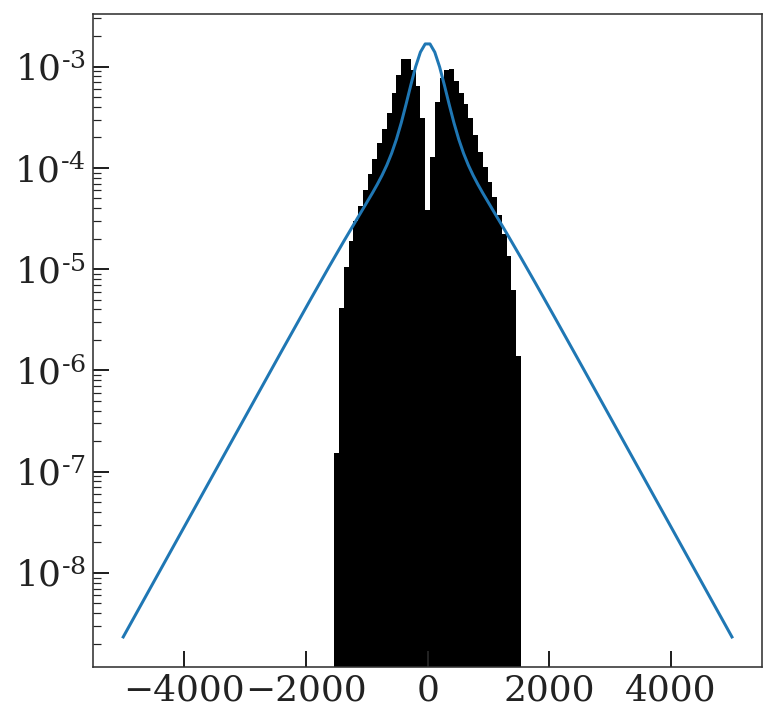

In [49]:
p0 = (
    np.log(gal.shape[0]),
    np.log(fiducial['h1']), 
    np.log(fiducial['h2']),
    fiducial['f'],
    fiducial['zsun'],
    fiducial['roll'],
)
p0_names = (
    'lnn0',
    'lnh1',
    'lnh2',
    'f',
    'zsun',
    'roll'
)
data = gal.cartesian.xyz.decompose(usys).value
like_args = (data, sgrA, ln_density_args, min_b, max_dist)
ln_likelihood(p0, *like_args, plot=True)

In [50]:
all_vals = np.linspace(0.75, 1.25, 15)[None] * np.array(p0)[:, None]
all_vals[-1] = np.linspace(-0.3, 0.3, all_vals[-1].size) # roll

all_lls = []
for i in range(len(p0)):
    print(i)
    this_p0 = np.array(p0, copy=True)
    lls = []
    vals = all_vals[i]
    for j, val in enumerate(vals):
        print(f"{j+1}/{len(vals)}", end="\r")
        this_p0[i] = val
        lls.append(ln_likelihood(this_p0, *like_args))
    all_lls.append(lls)
all_lls = np.array(all_lls)

0
15/15
25/15
35/15
45/15
55/15


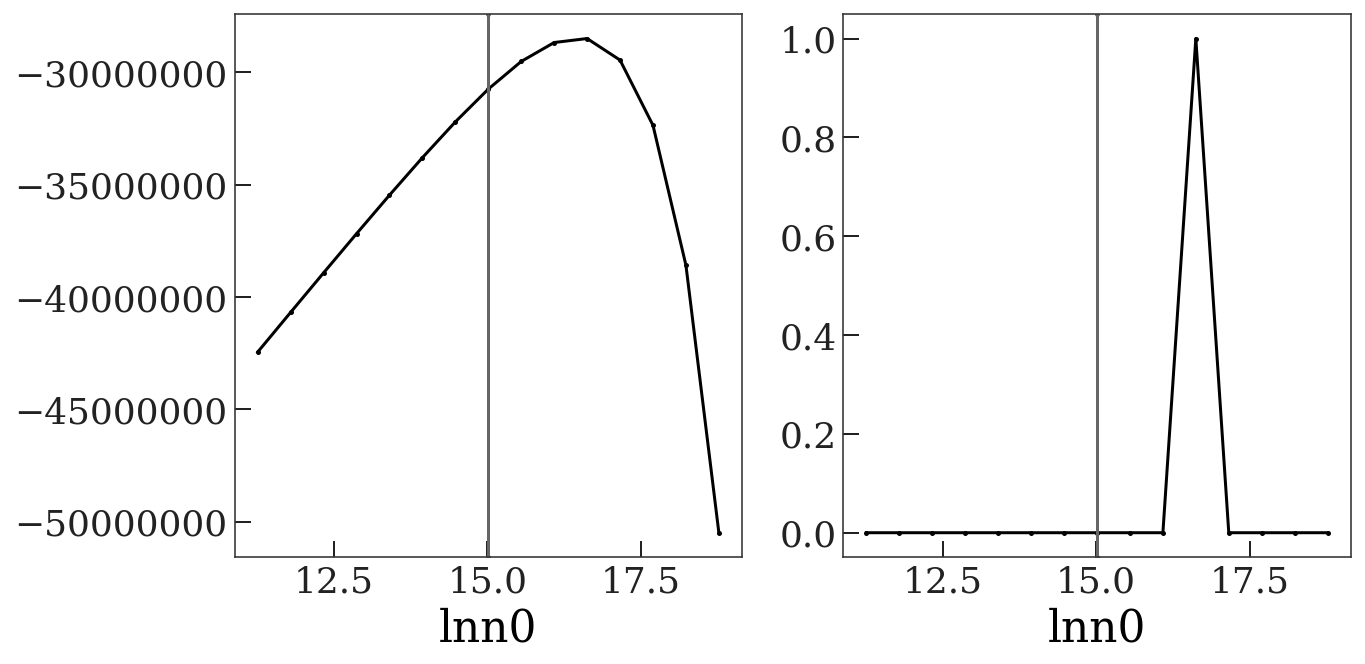

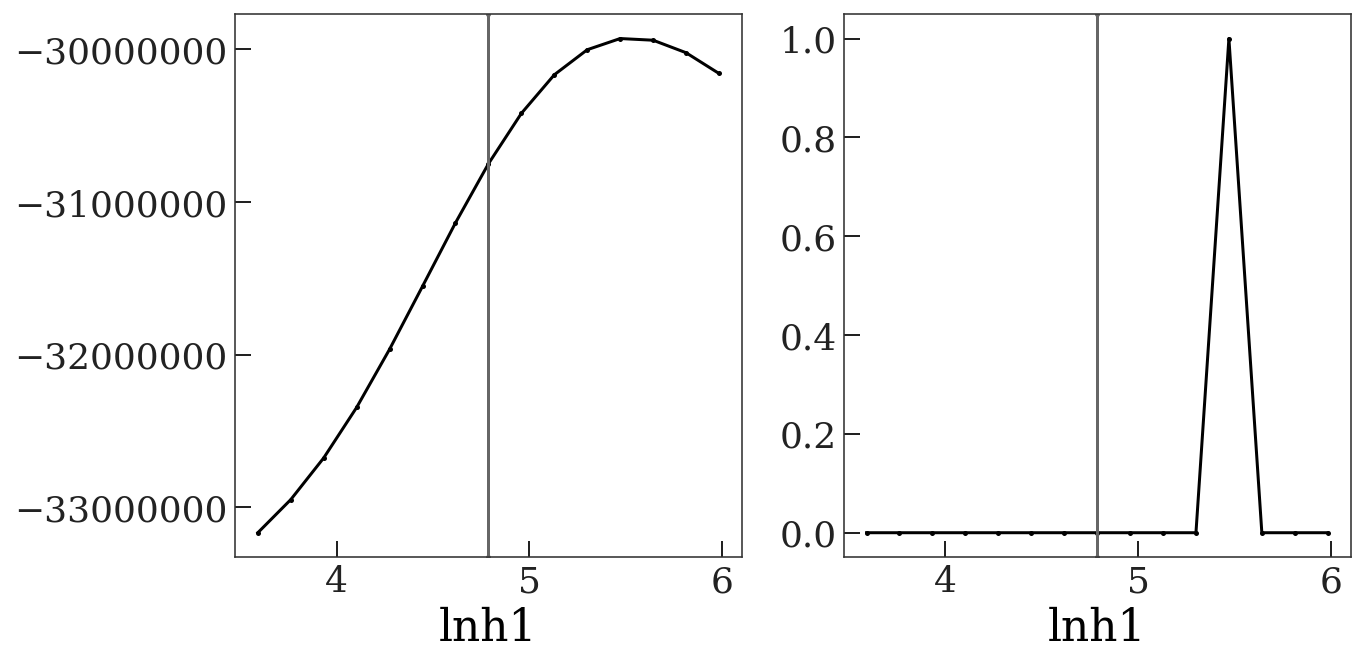

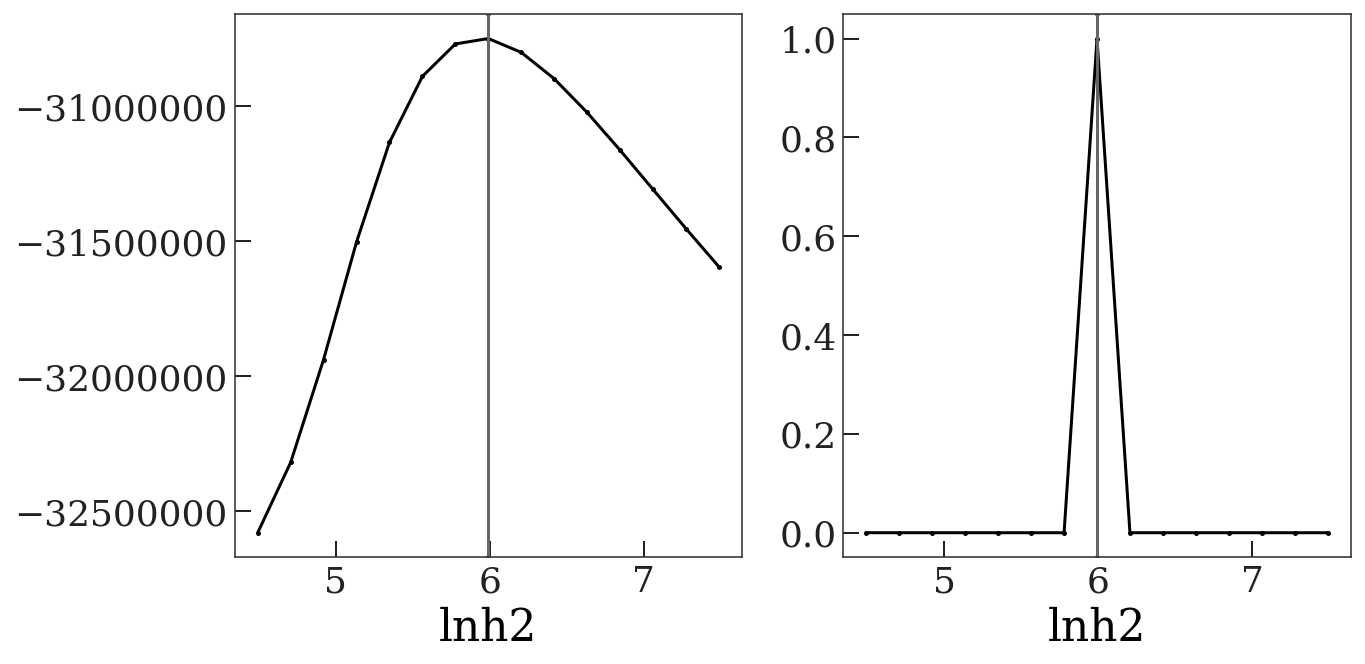

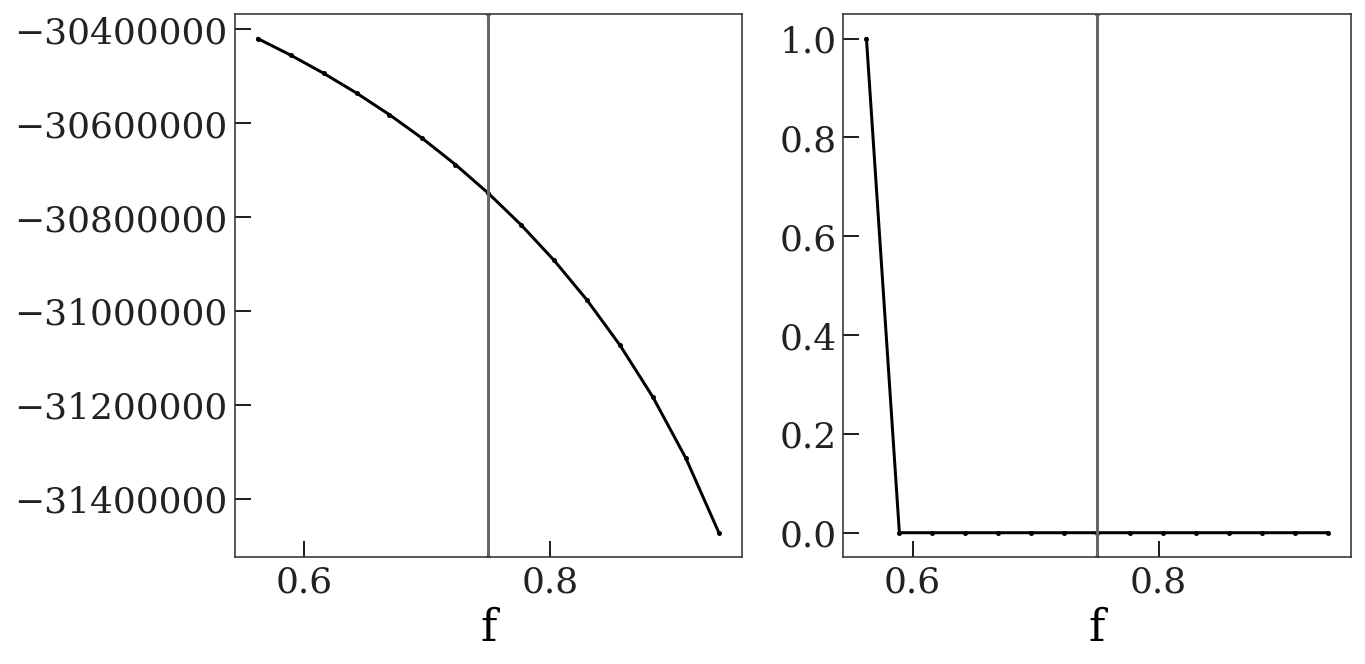

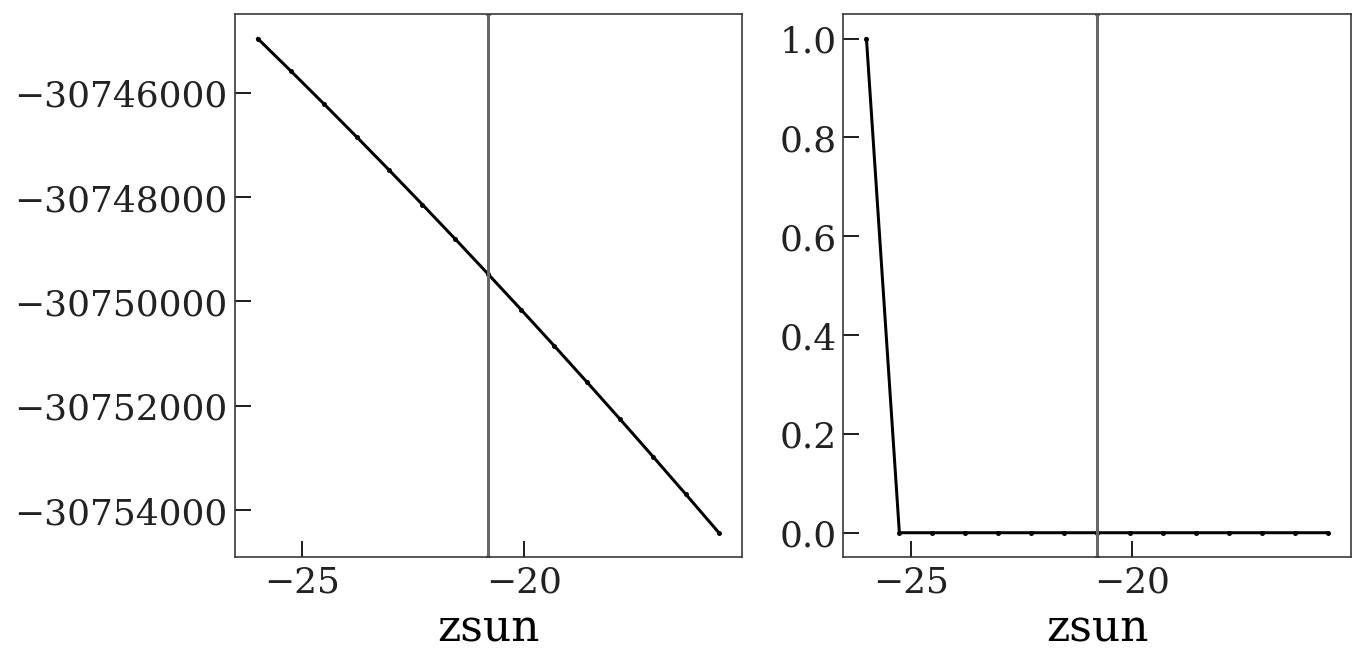

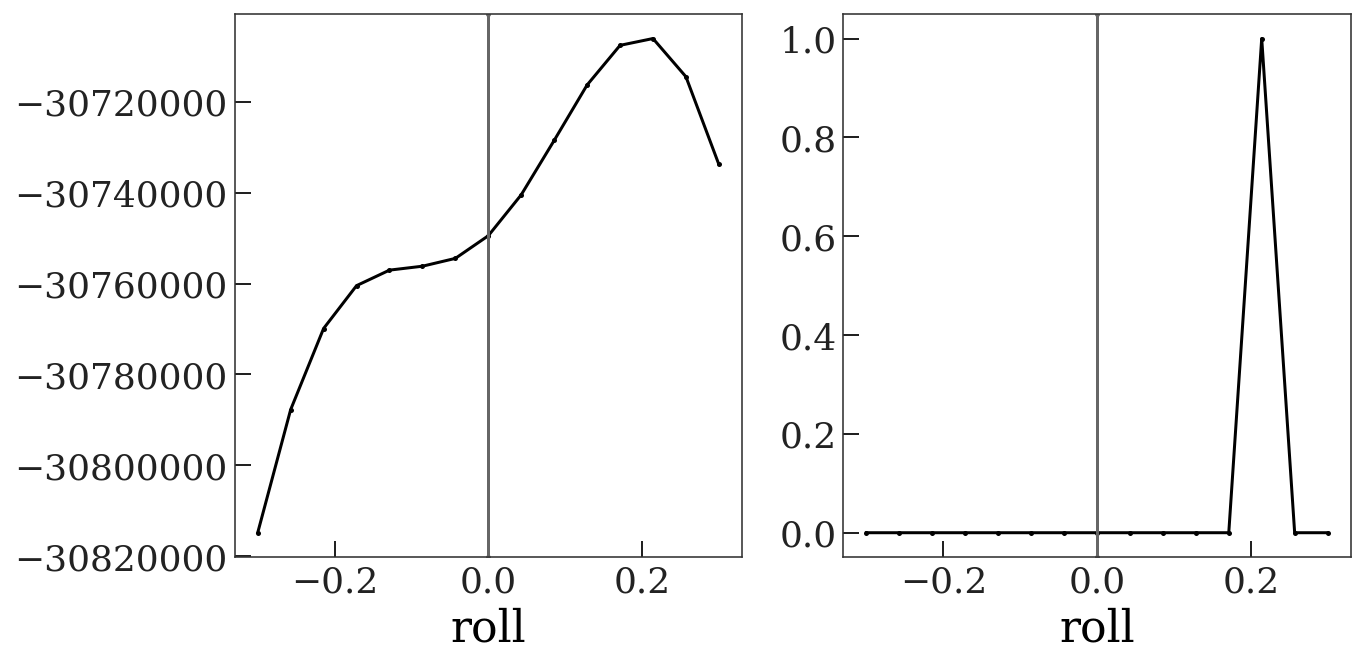

In [51]:
for i in range(all_lls.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(all_vals[i], all_lls[i])
    axes[1].plot(all_vals[i], np.exp(all_lls[i] - all_lls[i].max()))
    for ax in axes:
        ax.set_xlabel(p0_names[i])
        ax.axvline(p0[i])

In [54]:
full_res = minimize(
    lambda *args: -ln_likelihood(*args), 
    x0=p0, 
    args=like_args, 
    method='nelder-mead'
)

/mnt/ceph/users/apricewhelan/projects/solar-velocity/notebooks/model_helpers.py:50: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))
